In [1]:
# 导入数据操作和数学运算需要的库
import pandas as pd
import numpy as np
from math import sqrt

# 导入机器学习模型和评估指标
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc, classification_report

# 导入模型训练和评估工具
from sklearn.model_selection import train_test_split

# 导入可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 导入XGBoost，一个高效的机器学习算法
import xgboost as xgb

# 设置警告过滤器以忽略不必要的警告
import warnings
warnings.filterwarnings('ignore')

# 配置matplotlib以支持中文字符，并进行美观调整
plt.rcParams['font.sans-serif'] = ['simhei']  # 设置sans-serif字体为simhei
plt.rcParams['font.serif'] = ['simhei']       # 设置serif字体为simhei
plt.rcParams['axes.unicode_minus'] = False    # 确保负号显示正常

# 配置seaborn以保持一致的美学风格和字体支持
sns.set_style("darkgrid", {"font.sans-serif": ['simhei', 'Droid Sans Fallback']})

C:\Users\Stream\AppData\Roaming\spsspro\spsspro\lib\python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data=pd.read_csv('A题-示例数据/附件1/M101.csv')
data.head()

,日期,时间,生产线编号,物料推送气缸推送状态,物料推送气缸收回状态,物料推送数,物料待抓取数,放置容器数,容器上传检测数,填装检测数,...,不合格数,物料推送装置故障1001,物料检测装置故障2001,填装装置检测故障4001,填装装置定位故障4002,填装装置填装故障4003,加盖装置定位故障5001,加盖装置加盖故障5002,拧盖装置定位故障6001,拧盖装置拧盖故障6002
0,1,0,M101,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,M101,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,M101,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,M101,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,M101,0,1,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.shape

(636509, 37)

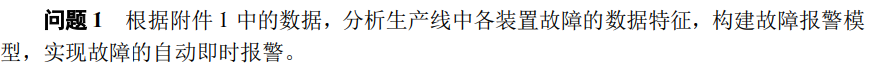

In [4]:
X =data[[ '时间', '物料推送气缸推送状态', '物料推送气缸收回状态', '物料推送数', '物料待抓取数',
       '放置容器数', '容器上传检测数', '填装检测数', '填装定位器固定状态', '填装定位器放开状态', '物料抓取数', '填装旋转数',
       '填装下降数', '填装数', '加盖检测数', '加盖定位数', '推盖数', '加盖下降数', '加盖数', '拧盖检测数',
       '拧盖定位数', '拧盖下降数', '拧盖旋转数', '拧盖数', '合格数', '不合格数']]

In [5]:
kk='物料检测装置故障2001'

In [6]:
data[kk].unique()

array([   0, 2001], dtype=int64)

In [7]:

data[kk]=data[kk].apply(lambda x :0 if x==0 else 1 )


data[kk].value_counts()

0    636005
1       504
Name: 物料检测装置故障2001, dtype: int64

In [8]:
Y =data[kk]

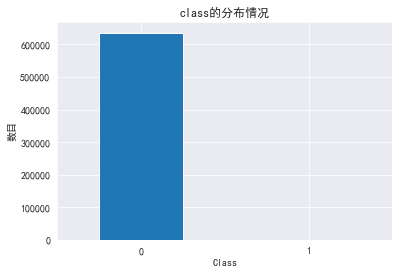

In [9]:
count_classes = pd.value_counts(Y,sort = True).sort_index()
count_classes.plot(kind='bar',rot=0)
plt.title('class的分布情况')
plt.xlabel('Class')
plt.ylabel('数目')
plt.show()


In [10]:
from collections import Counter
Counter(Y)

Counter({0: 636005, 1: 504})

In [12]:
from imblearn.over_sampling import SMOTE
X_resampled_SMOTE, y_resampled_SMOTE = SMOTE().fit_resample(X, Y)

In [13]:
from imblearn.under_sampling import RandomUnderSampler
X_resampled_RandomUnderSampler, y_resampled_RandomUnderSampler = RandomUnderSampler(random_state=42).fit_resample(X, Y)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

逻辑回归评价结果：
ACC 0.9995234429414568
REC 0.631578947368421
F-score 0.6784452296819787
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190801
           1       0.73      0.63      0.68       152

    accuracy                           1.00    190953
   macro avg       0.87      0.82      0.84    190953
weighted avg       1.00      1.00      1.00    190953

[13:28:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost模型评价结果：
ACC 0.9998743146219227
REC 0.8486842105263158
F-score 0.9148936170212766
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190801
           1       0.99      0.85      0.91       152

    accuracy                 

Text(0.5, 1.0, 'GBDT ROC(auc = 0.76)')

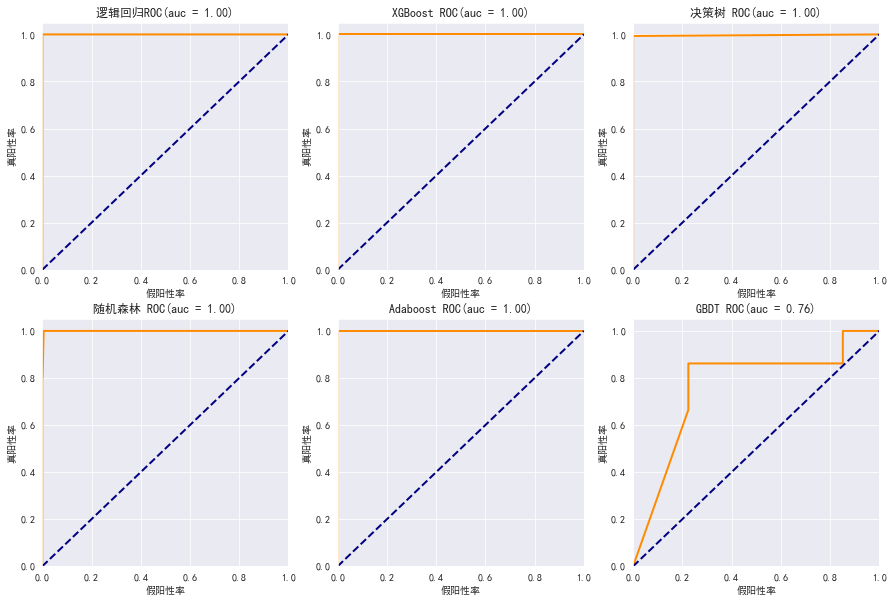

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train, Y_train)
LR_y_pred = model.predict(X_test)

# 输出xgboost模型评价结果
print('逻辑回归评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, LR_y_pred))
print("REC",recall_score(Y_test, LR_y_pred))
print("F-score",f1_score(Y_test, LR_y_pred))
print(classification_report(Y_test, LR_y_pred))

y_pred_prob = model.predict_proba(X_test)[:, 1]

    # 计算ROC曲线的TPR和FPR
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    # 计算AUC值
roc_auc = auc(fpr, tpr)


axs[0][0].plot(fpr, tpr, color='darkorange', lw=2)
axs[0][0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0][0].set_xlim([0.0, 1.0])
axs[0][0].set_ylim([0.0, 1.05])
axs[0][0].set_xlabel('假阳性率')
axs[0][0].set_ylabel('真阳性率')
axs[0][0].set_title('逻辑回归ROC(auc = %0.2f)' % roc_auc)






##'Q2-出生年', 'Q3-性别',  'Q6-文化程度', 'Q7-婚姻状况','Q8-职业'
#年龄、性别、婚姻状况、文化程度、职业
# 构建xgboost回归模型
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, Y_train)
xgb_y_pred = xgb_model.predict(X_test)

# 输出xgboost模型评价结果
print('XGBoost模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, xgb_y_pred))
print("REC",recall_score(Y_test, xgb_y_pred))
print("F-score",f1_score(Y_test, xgb_y_pred))
print(classification_report(Y_test, xgb_y_pred))

u=0
o=1
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('XGBoost ROC(auc = %0.2f)' % roc_auc)








# 构建决策树回归模型
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, Y_train)
tree_y_pred = tree_model.predict(X_test)

# 输出决策树模型评价结果
print('决策树模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, tree_y_pred))
print("REC",recall_score(Y_test, tree_y_pred))
print("F-score",f1_score(Y_test, tree_y_pred))
print(classification_report(Y_test, tree_y_pred))
u=0
o=2
y_pred_prob = tree_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('决策树 ROC(auc = %0.2f)' % roc_auc)





# 构建随机森林回归模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(X_train, Y_train)
rf_y_pred = rf_model.predict(X_test)

# 输出随机森林模型评价结果
print('随机森林模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, rf_y_pred))
print("REC",recall_score(Y_test, rf_y_pred))
print("F-score",f1_score(Y_test, rf_y_pred))
print(classification_report(Y_test, rf_y_pred))
u=1
o=0
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('随机森林 ROC(auc = %0.2f)' % roc_auc)



# 构建Adaboost回归模型
ada_model = AdaBoostClassifier(n_estimators=100)
ada_model.fit(X_train, Y_train)
ada_y_pred = ada_model.predict(X_test)
# 输出Adaboost模型评价结果
print('Adaboost模型评价结果：')
print("ACC",accuracy_score(Y_test, ada_y_pred))
print("REC",recall_score(Y_test, ada_y_pred))
print("F-score",f1_score(Y_test, ada_y_pred))
print(classification_report(Y_test, ada_y_pred))
u=1
o=1
y_pred_prob = ada_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('Adaboost ROC(auc = %0.2f)' % roc_auc)

# 构建GBDT回归模型
gbdt_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
gbdt_model.fit(X_train, Y_train)
gbdt_y_pred = gbdt_model.predict(X_test)

# 输出GBDT模型评价结果
print('GBDT模型评价结果：')
print("ACC",accuracy_score(Y_test, gbdt_y_pred))
print("REC",recall_score(Y_test, gbdt_y_pred))
print("F-score",f1_score(Y_test, gbdt_y_pred))
print(classification_report(Y_test, gbdt_y_pred))
u=1
o=2
y_pred_prob = gbdt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('GBDT ROC(auc = %0.2f)' % roc_auc)


In [18]:
fig.savefig('./jpglist/%sROC_原始数据.png'%kk)

In [19]:
from collections import Counter
Counter(y_resampled_SMOTE)

Counter({0: 636005, 1: 636005})

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled_SMOTE, y_resampled_SMOTE ,test_size=0.3)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train, Y_train)
LR_y_pred = model.predict(X_test)

# 输出xgboost模型评价结果
print('逻辑回归评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, LR_y_pred))
print("REC",recall_score(Y_test, LR_y_pred))
print("F-score",f1_score(Y_test, LR_y_pred))
print(classification_report(Y_test, LR_y_pred))

y_pred_prob = model.predict_proba(X_test)[:, 1]

    # 计算ROC曲线的TPR和FPR
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    # 计算AUC值
roc_auc = auc(fpr, tpr)


axs[0][0].plot(fpr, tpr, color='darkorange', lw=2)
axs[0][0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0][0].set_xlim([0.0, 1.0])
axs[0][0].set_ylim([0.0, 1.05])
axs[0][0].set_xlabel('假阳性率')
axs[0][0].set_ylabel('真阳性率')
axs[0][0].set_title('逻辑回归ROC(auc = %0.2f)' % roc_auc)






##'Q2-出生年', 'Q3-性别',  'Q6-文化程度', 'Q7-婚姻状况','Q8-职业'
#年龄、性别、婚姻状况、文化程度、职业
# 构建xgboost回归模型
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, Y_train)
xgb_y_pred = xgb_model.predict(X_test)

# 输出xgboost模型评价结果
print('XGBoost模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, xgb_y_pred))
print("REC",recall_score(Y_test, xgb_y_pred))
print("F-score",f1_score(Y_test, xgb_y_pred))
print(classification_report(Y_test, xgb_y_pred))

u=0
o=1
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('XGBoost ROC(auc = %0.2f)' % roc_auc)








# 构建决策树回归模型
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, Y_train)
tree_y_pred = tree_model.predict(X_test)

# 输出决策树模型评价结果
print('决策树模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, tree_y_pred))
print("REC",recall_score(Y_test, tree_y_pred))
print("F-score",f1_score(Y_test, tree_y_pred))
print(classification_report(Y_test, tree_y_pred))
u=0
o=2
y_pred_prob = tree_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('决策树 ROC(auc = %0.2f)' % roc_auc)





# 构建随机森林回归模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(X_train, Y_train)
rf_y_pred = rf_model.predict(X_test)

# 输出随机森林模型评价结果
print('随机森林模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, rf_y_pred))
print("REC",recall_score(Y_test, rf_y_pred))
print("F-score",f1_score(Y_test, rf_y_pred))
print(classification_report(Y_test, rf_y_pred))
u=1
o=0
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('随机森林 ROC(auc = %0.2f)' % roc_auc)



# 构建Adaboost回归模型
ada_model = AdaBoostClassifier(n_estimators=100)
ada_model.fit(X_train, Y_train)
ada_y_pred = ada_model.predict(X_test)
# 输出Adaboost模型评价结果
print('Adaboost模型评价结果：')
print("ACC",accuracy_score(Y_test, ada_y_pred))
print("REC",recall_score(Y_test, ada_y_pred))
print("F-score",f1_score(Y_test, ada_y_pred))
print(classification_report(Y_test, ada_y_pred))
u=1
o=1
y_pred_prob = ada_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('Adaboost ROC(auc = %0.2f)' % roc_auc)

# 构建GBDT回归模型
gbdt_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
gbdt_model.fit(X_train, Y_train)
gbdt_y_pred = gbdt_model.predict(X_test)

# 输出GBDT模型评价结果
print('GBDT模型评价结果：')
print("ACC",accuracy_score(Y_test, gbdt_y_pred))
print("REC",recall_score(Y_test, gbdt_y_pred))
print("F-score",f1_score(Y_test, gbdt_y_pred))
print(classification_report(Y_test, gbdt_y_pred))
u=1
o=2
y_pred_prob = gbdt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('GBDT ROC(auc = %0.2f)' % roc_auc)


逻辑回归评价结果：
ACC 0.999515202972723
REC 1.0
F-score 0.9995158500234224
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190639
           1       1.00      1.00      1.00    190964

    accuracy                           1.00    381603
   macro avg       1.00      1.00      1.00    381603
weighted avg       1.00      1.00      1.00    381603

[13:35:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost模型评价结果：
ACC 0.998645188848096
REC 1.0
F-score 0.9986481716325223
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190639
           1       1.00      1.00      1.00    190964

    accuracy                           1.00    381603
   mac

In [ ]:
fig.savefig('./jpglist/%sROC_smote.png'%kk)

In [ ]:
Counter(y_resampled_RandomUnderSampler)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled_RandomUnderSampler, y_resampled_RandomUnderSampler, test_size=0.3)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train, Y_train)
LR_y_pred = model.predict(X_test)

# 输出xgboost模型评价结果
print('逻辑回归评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, LR_y_pred))
print("REC",recall_score(Y_test, LR_y_pred))
print("F-score",f1_score(Y_test, LR_y_pred))
print(classification_report(Y_test, LR_y_pred))

y_pred_prob = model.predict_proba(X_test)[:, 1]

    # 计算ROC曲线的TPR和FPR
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    # 计算AUC值
roc_auc = auc(fpr, tpr)


axs[0][0].plot(fpr, tpr, color='darkorange', lw=2)
axs[0][0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0][0].set_xlim([0.0, 1.0])
axs[0][0].set_ylim([0.0, 1.05])
axs[0][0].set_xlabel('假阳性率')
axs[0][0].set_ylabel('真阳性率')
axs[0][0].set_title('逻辑回归ROC(auc = %0.2f)' % roc_auc)






##'Q2-出生年', 'Q3-性别',  'Q6-文化程度', 'Q7-婚姻状况','Q8-职业'
#年龄、性别、婚姻状况、文化程度、职业
# 构建xgboost回归模型
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, Y_train)
xgb_y_pred = xgb_model.predict(X_test)

# 输出xgboost模型评价结果
print('XGBoost模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, xgb_y_pred))
print("REC",recall_score(Y_test, xgb_y_pred))
print("F-score",f1_score(Y_test, xgb_y_pred))
print(classification_report(Y_test, xgb_y_pred))

u=0
o=1
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('XGBoost ROC(auc = %0.2f)' % roc_auc)








# 构建决策树回归模型
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, Y_train)
tree_y_pred = tree_model.predict(X_test)

# 输出决策树模型评价结果
print('决策树模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, tree_y_pred))
print("REC",recall_score(Y_test, tree_y_pred))
print("F-score",f1_score(Y_test, tree_y_pred))
print(classification_report(Y_test, tree_y_pred))
u=0
o=2
y_pred_prob = tree_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('决策树 ROC(auc = %0.2f)' % roc_auc)





# 构建随机森林回归模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(X_train, Y_train)
rf_y_pred = rf_model.predict(X_test)

# 输出随机森林模型评价结果
print('随机森林模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, rf_y_pred))
print("REC",recall_score(Y_test, rf_y_pred))
print("F-score",f1_score(Y_test, rf_y_pred))
print(classification_report(Y_test, rf_y_pred))
u=1
o=0
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('随机森林 ROC(auc = %0.2f)' % roc_auc)



# 构建Adaboost回归模型
ada_model = AdaBoostClassifier(n_estimators=100)
ada_model.fit(X_train, Y_train)
ada_y_pred = ada_model.predict(X_test)
# 输出Adaboost模型评价结果
print('Adaboost模型评价结果：')
print("ACC",accuracy_score(Y_test, ada_y_pred))
print("REC",recall_score(Y_test, ada_y_pred))
print("F-score",f1_score(Y_test, ada_y_pred))
print(classification_report(Y_test, ada_y_pred))
u=1
o=1
y_pred_prob = ada_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('Adaboost ROC(auc = %0.2f)' % roc_auc)

# 构建GBDT回归模型
gbdt_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
gbdt_model.fit(X_train, Y_train)
gbdt_y_pred = gbdt_model.predict(X_test)

# 输出GBDT模型评价结果
print('GBDT模型评价结果：')
print("ACC",accuracy_score(Y_test, gbdt_y_pred))
print("REC",recall_score(Y_test, gbdt_y_pred))
print("F-score",f1_score(Y_test, gbdt_y_pred))
print(classification_report(Y_test, gbdt_y_pred))
u=1
o=2
y_pred_prob = gbdt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[u][o].plot(fpr, tpr, color='darkorange', lw=2)
axs[u][o].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[u][o].set_xlim([0.0, 1.0])
axs[u][o].set_ylim([0.0, 1.05])
axs[u][o].set_xlabel('假阳性率')
axs[u][o].set_ylabel('真阳性率')
axs[u][o].set_title('GBDT ROC(auc = %0.2f)' % roc_auc)


In [ ]:
fig.savefig('./jpglist/%sROC_下采样.png'%kk)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [16]:

# 构建xgboost回归模型
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, Y_train)
xgb_y_pred = xgb_model.predict(X_test)

# 输出xgboost模型评价结果
print('XGBoost模型评价结果：')
# 准确率，召回率，F-score评价
print("ACC",accuracy_score(Y_test, xgb_y_pred))
print("REC",recall_score(Y_test, xgb_y_pred))
print("F-score",f1_score(Y_test, xgb_y_pred))
print(classification_report(Y_test, xgb_y_pred))




[13:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost模型评价结果：
ACC 0.9998690777311694
REC 0.8466257668711656
F-score 0.9169435215946844
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190790
           1       1.00      0.85      0.92       163

    accuracy                           1.00    190953
   macro avg       1.00      0.92      0.96    190953
weighted avg       1.00      1.00      1.00    190953



F1分数: 0.9169435215946844


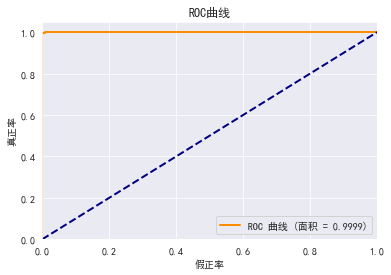

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt

# 预测测试集的概率而不是类别
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# 计算F1分数
xgb_f1_score = f1_score(Y_test, xgb_model.predict(X_test))
print(f'F1分数: {xgb_f1_score}')

# 计算真正率（TPR）和假正率（FPR）以及阈值
fpr, tpr, thresholds = roc_curve(Y_test, xgb_y_pred_proba)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC 曲线 (面积 = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率')
plt.ylabel('真正率')
plt.title('ROC曲线')
plt.legend(loc="lower right")
plt.show()

F1分数: 0.9169435215946844


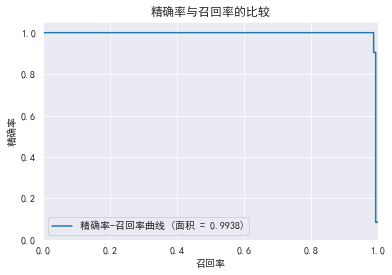

In [18]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


xgb_y_pred = xgb_model.predict(X_test)

# 计算F1分数
xgb_f1_score = f1_score(Y_test, xgb_y_pred)
print(f'F1分数: {xgb_f1_score}')

# 预测概率
xgb_y_scores = xgb_model.predict_proba(X_test)[:, 1]

# 获取精确率和召回率
precision, recall, thresholds = precision_recall_curve(Y_test, xgb_y_scores)

# 计算精确率-召回率曲线下面积(AUC)
pr_auc = auc(recall, precision)


# 绘制精确率-召回率曲线
plt.figure()
plt.plot(recall, precision, label='精确率-召回率曲线 (面积 = {0:0.4f})'.format(pr_auc))
plt.xlabel('召回率')
plt.ylabel('精确率')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('精确率与召回率的比较')
plt.legend(loc="lower left")
plt.show()


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,xgb_y_pred)

array([[190790,      0],
       [    25,    138]], dtype=int64)

F1 Score: 0.9169435215946844
混淆矩阵：
[[190790      0]
 [    25    138]]


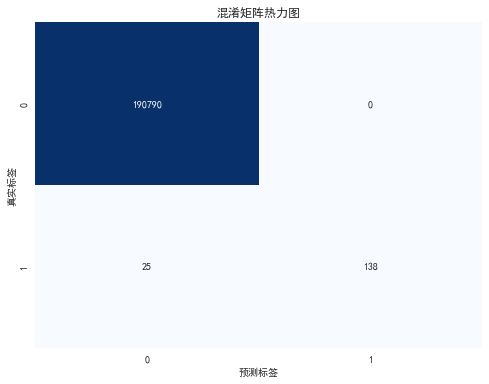

In [20]:

xgb_y_pred = xgb_model.predict(X_test)

# 计算F1分数
print(f"F1 Score: {f1_score(Y_test, xgb_y_pred)}")

# 生成混淆矩阵
cm = confusion_matrix(Y_test, xgb_y_pred)
print("混淆矩阵：")
print(cm)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('混淆矩阵热力图')
plt.show()


In [21]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X, Y)

[13:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
import joblib



# save the model
joblib.dump(xgb_model, './modellist/Q1_%s.bin'%kk)


['./modellist/Q1_物料检测装置故障2001.bin']

In [23]:
import shap
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 初始化SHAP模型
explainer = shap.Explainer(xgb_model)

# 计算SHAP值
shap_values = explainer(X)

In [24]:
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

In [25]:
# 输出每个特征的SHAP值（绝对值）
features=[]
abs_mean_shap_values=[]
for i, feature in enumerate(X.columns):
    abs_mean_shap_value = np.abs(shap_df.values[:, i]).mean()
    features.append(feature)
    abs_mean_shap_values.append(abs_mean_shap_value)


In [26]:
tt=pd.DataFrame(features,columns=['features'])
tt['shap_values']=abs_mean_shap_values

In [27]:
tt.sort_values(by='shap_values', ascending=False)

,features,shap_values
9,填装定位器放开状态,1.217869
3,物料推送数,0.823044
4,物料待抓取数,0.624777
0,时间,0.406769
7,填装检测数,0.299122
11,填装旋转数,0.283625
5,放置容器数,0.245882
25,不合格数,0.222186
24,合格数,0.065613
1,物料推送气缸推送状态,0.064610


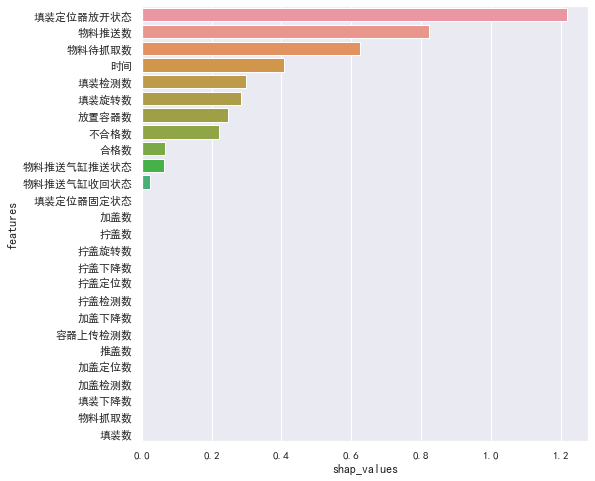

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.rcParams['font.sans-serif'] = ['SimHei']  
# Matplotlib中设置字体-黑体，解决Matplotlib中文乱码问题
plt.rcParams['axes.unicode_minus'] = False    
# 解决Matplotlib坐标轴负号'-'显示为方块的问题
sns.set(font='SimHei')                        
# Seaborn中设置字体-黑体，解决Seaborn中文乱码问题
a_sorted = tt.sort_values(by='shap_values', ascending=False)

# 设置图表大小，例如设置为宽10英寸，高6英寸
plt.figure(figsize=(8, 8))
# 使用Seaborn绘制柱状图
sns.barplot(x='shap_values', y='features', data=a_sorted.reset_index(), orient='h')

# 显示图形
plt.show()

In [29]:

# 初始化SHAP模型
explainer = shap.Explainer(xgb_model)

shap.initjs() #初始化JS
shap_values = explainer.shap_values(X) #计算每个样本的每个特征的SHAP值

In [30]:
i=data[data[kk]==1].index[1]
shap.force_plot(explainer.expected_value, shap_values[i,:], data[X.columns].iloc[i,:]) 

In [31]:
i=data[data[kk]==0].index[0]
shap.force_plot(explainer.expected_value, shap_values[i,:], data[X.columns].iloc[i,:]) 

In [ ]:
print(1)
shap.summary_plot(shap_values, X[X.columns])

1
